# Set-up


In [1]:
!pip install easyocr
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 17.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
import easyocr
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm
import json
import os
from math import floor, ceil
import uuid

# EasyOcr'ing

In [3]:
reader = easyocr.Reader(['ru'])

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.1% Complete

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dataset_path = Path('/content/drive/MyDrive/receipt_dataset/test/')
image_path = list(dataset_path.glob('*.png'))[7]
print(image_path)

/content/drive/MyDrive/receipt_dataset/test/peter_9.png


In [6]:
ocr_result = reader.readtext(str(image_path))
print(ocr_result)

[([[123, 29], [255, 29], [255, 43], [123, 43]], 'Кассовый чек: Приход', 0.7380370244721149), ([[139, 51], [249, 51], [249, 63], [139, 63]], 'Дидитвл Тек Энд Лаб', 0.80594632450983), ([[123, 69], [253, 69], [253, 81], [123, 81]], '24.10.2023 17-14-00 +03.00', 0.7676593923900151), ([[11, 111], [65, 111], [65, 123], [11, 123]], 'Номер чекв', 0.49362333199292524), ([[253, 109], [367, 109], [367, 123], [253, 123]], '6383376+452554214451', 0.4062225935606199), ([[12, 132], [42, 132], [42, 140], [12, 140]], 'енена', 0.25897219805741095), ([[9, 151], [35, 151], [35, 163], [9, 163]], 'ИНН', 0.98765772401179), ([[307, 151], [367, 151], [367, 163], [307, 163]], '9717073792', 0.9818703653349755), ([[11, 171], [37, 171], [37, 185], [11, 185]], 'СНО', 0.4518713195929761), ([[341, 171], [367, 171], [367, 185], [341, 185]], 'ОСН', 0.5992971279213414), ([[20, 254], [165, 254], [165, 269], [20, 269]], 'Услуги обпачной платформь', 0.8996459291715515), ([[169, 257], [237, 257], [237, 269], [169, 269]], '#

In [7]:
def create_bounding_box(bbox_data):
    xs = []
    ys = []
    for x, y in bbox_data:
        xs.append(x)
        ys.append(y)

    left = int(min(xs))
    top = int(min(ys))
    right = int(max(xs))
    bottom = int(max(ys))

    return [left, top, right, bottom]

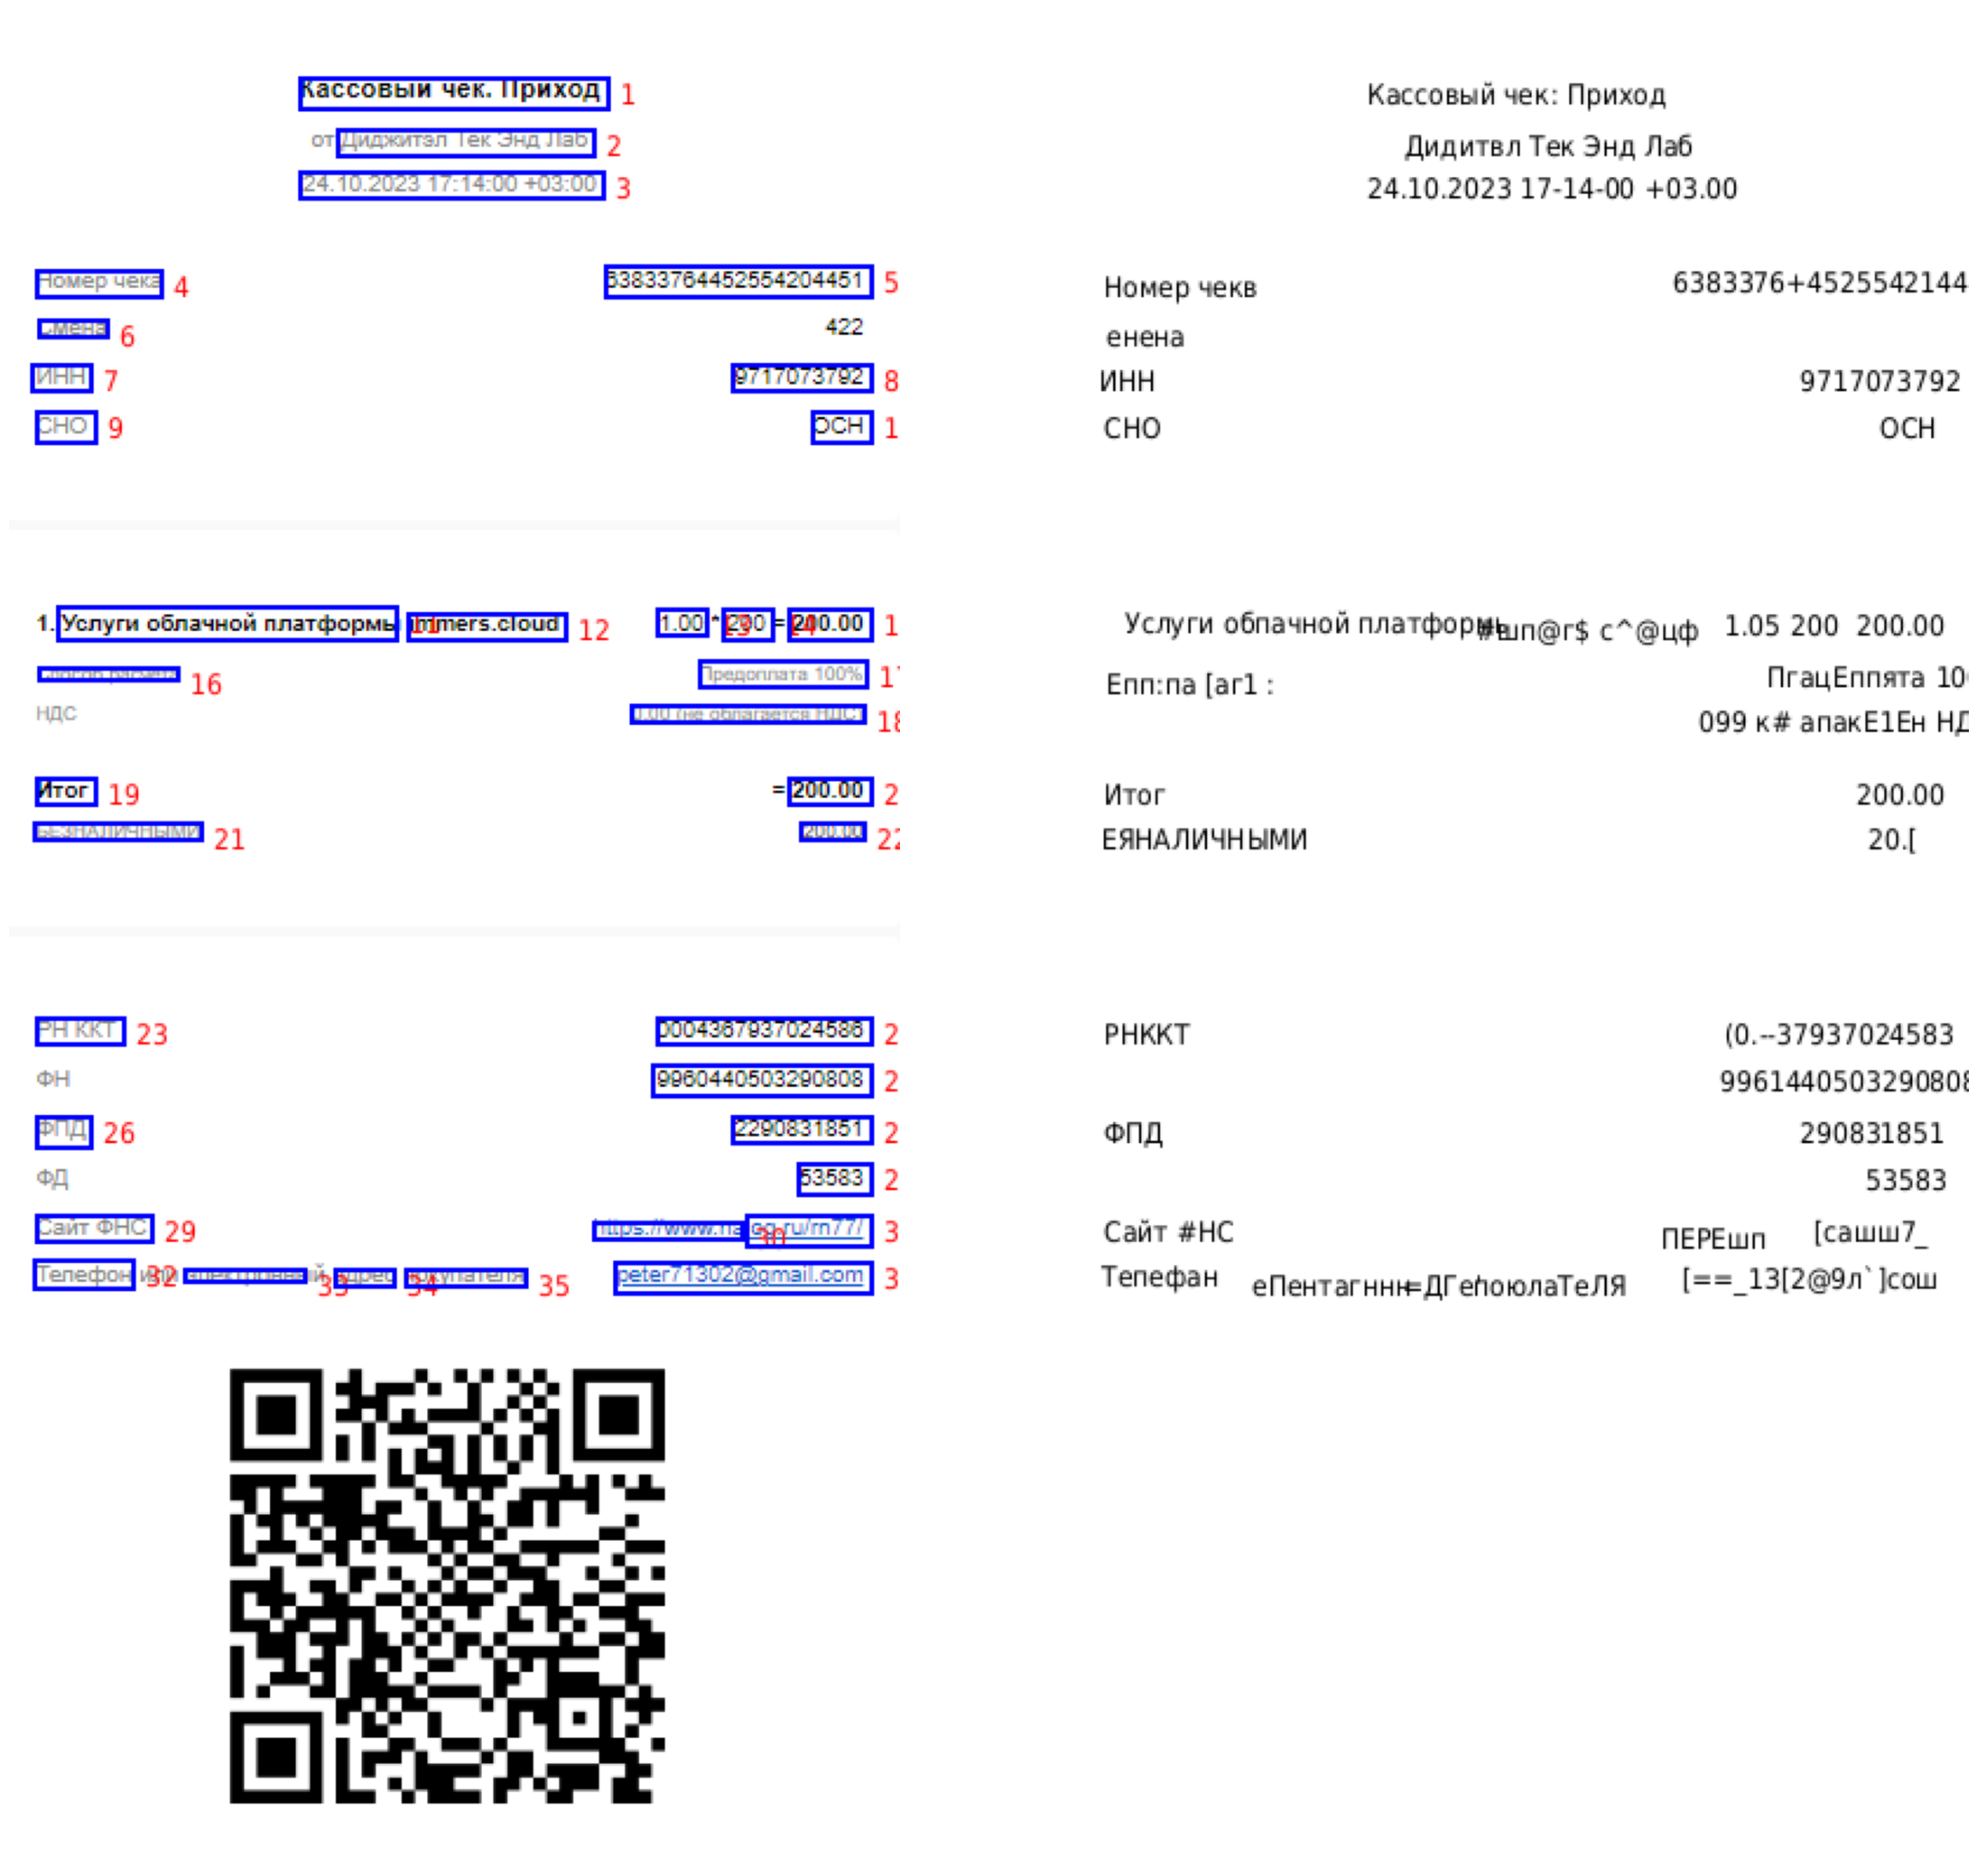

In [8]:
font_path = Path(cv2.__path__[0]) / "qt/fonts/DejaVuSansCondensed.ttf"
font = ImageFont.truetype(str(font_path), size=12)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(28, 28))

left_image = Image.open(image_path).convert("RGB")
right_image = Image.new("RGB", left_image.size, (255, 255, 255))

left_draw = ImageDraw.Draw(left_image)
right_draw = ImageDraw.Draw(right_image)

for i, (bbox, word, confidence) in enumerate(ocr_result):
    box = create_bounding_box(bbox)

    left_draw.rectangle(box, outline="blue", width=2)
    left, top, right, bottom = box

    left_draw.text((right + 5, top), text=str(i + 1), fill="red", font=font)
    right_draw.text((left, top), text=word, fill="black", font=font)

ax1.imshow(left_image)
ax2.imshow(right_image)
ax1.axis("off");
ax2.axis("off");

In [9]:
def create_image_url(filepath):
    filename = os.path.basename(filepath)
    return f'http://25.17.13.213:8080/data/local-files/?d=train%5C{filename}'

In [10]:
# saving results to ls json format

def convert_to_ls(image: Image, ocr_output):
  image_width, image_height = image.size
  results = []
  all_scores = []

  for i, (bbox, word, confidence) in enumerate(ocr_output):
    left, top, right, bottom = create_bounding_box(bbox)
    bbox_ls = {
        'x': 100 * left / image_width,
        'y': 100 * top / image_height,
        'width': 100 * (right - left) / image_width,
        'height': 100 * (bottom - top) / image_height,
        'rotation': 0
    }

    text = ' '.join([w for w in word.split()]).strip()
    if not text:
      continue

    region_id = str(uuid.uuid4())[:10]
    bbox_result = {
        'id': region_id, 'from_name': 'bbox', 'to_name': 'image',
        'type': 'rectangle', 'value': bbox_ls
        }
    transcription_result = {
        'id': region_id, 'from_name': 'transcription', 'to_name': 'image',
        'type': 'textarea', 'value': dict(text=[text]), 'score': confidence
        }
    results.extend([bbox_result, transcription_result])
    all_scores.append(confidence)

  return {
      'data': {
          'ocr': create_image_url(image.filename)
      },
      'predictions': [{
          'result': results,
          'score': sum(all_scores) / len(all_scores) if all_scores else 0
      }]
  }



In [11]:
# im = Image.open(image_path)
# output_ex = reader.readtext(im)
# result = convert_to_ls(im, output_ex)
# result

In [12]:
# using script above for creating json file for all images in ds

tasks = []
for image_path in dataset_path.glob('*.png'):
  ocr_output = reader.readtext(str(image_path))
  task = convert_to_ls(Image.open(image_path), ocr_output)
  tasks.append(task)

json_path = '/content/drive/MyDrive/receipt_dataset/new_ocr_tasks.json'
with open(json_path, mode='w') as f:
  json.dump(tasks, f, indent=2)